Let's start with importing necessary libraries

In [1]:
### Problem Solution to show arabic letters from right to left
! pip install arabic_reshaper
! pip install python-bidi

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
import json
import tensorflow as tf
import unicodedata
import re
import os

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

#sns.color_palette("rocket_r", as_cmap=True)
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
plt.rcParams.update({'font.size': 22})
np.random.seed(42)
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

> Show available files

In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/alldialectdataset/out.csv


Using `arabic_reshaper` library to reconstruct Arabic sentences to be used in applications that don't support Arabic script.

Text(0.25, 0.45, 'ﺔﻴﺑﺮﻋ ﺔﻐﻟ')

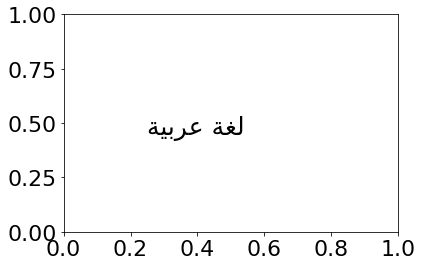

In [4]:
import arabic_reshaper
from bidi.algorithm import get_display

reshaped_text = arabic_reshaper.reshape(u'لغةٌ عربيّة')
artext = get_display(reshaped_text)

plt.text(0.25, 0.45, artext , name = 'Times New Roman',fontsize=25)

Reading dataset, drop id column that used to btain data texts from [API](https://recruitment.aimtechnologies.co/ai-tasks) then rename columns for our text to tweets. 

In [5]:
df = pd.read_csv("../input/alldialectdataset/out.csv", encoding="utf-8", lineterminator='\n')
df.drop(columns=["id"], inplace=True)
df.columns = ['dialect', 'tweets']
df.tail()

,dialect,tweets
458192,AE,@ArefHareb @AbdullaBnS ههههههه انا عسب جي منشن...
458193,OM,@OMAN_NT ماشي احساس بالمسؤليه،مثلا هذيلا لازم ...
458194,BH,@waseem_yousef و انا بعد اعترف انك غيرتني الله...
458195,EG,"الأسرة الفقيرة اللي كانت بتدعم السيسي عشان ""مس..."
458196,LY,من كثر ما تغيرت عليا يا صوتي مش عارفك لمين ، ه...


In [6]:
df.describe().T

,count,unique,top,freq
dialect,458197,18,EG,57636
tweets,457197,457197,يعني من الساعة 1 وانا بحاول انام ولهلا كل المح...,1


`dialect` column has 18 unique class and 'tweets' column has some null values to drop and zero dublicated tweets.

In [7]:
df.dropna(inplace=True)

Let's translate` dialect` column in arabic to an `arabic_dialects` column for some visualization plots.

In [8]:
arabic_dialects = {
    'AE': 'لهجة اماراتية',
    'BH': 'لهجة بحرينية',
    'DZ': 'لهجة جزائرية',
    'EG': 'لهجة مصرية',
    'IQ': 'لهجة عراقية',
    'JO': 'لهجة أردنية',
    'KW': 'لهجة كويتية',
    'LB': 'لهجة لبنانية',
    'LY': 'لهجة ليبية',
    'MA': 'لهجة مغربية',
    'OM': 'لهجة عمانية',
    'PL': 'لهجة فلسطينية',
    'QA': 'لهجة قطرية',
    'SA': 'لهجة سعودية',
    'SD': 'لهجة سودانية',
    'SY': 'لهجة سورية',
    'TN': 'لهجة تونسية',
    'YE': 'لهجة يمنية'
}
df['dialect_in_arabic'] = df.dialect.map(arabic_dialects)

Here we create a pie plot to show the percentage of each dialect. This plot shows that the largest percentage for egyptian dialects with 12.6% and the smallest is tunisian dialect with 2.02%.

In [9]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


values = df.dialect_in_arabic.value_counts();
labels = values.index

fig = go.Figure(
    [
        go.Pie(
            labels = labels,
            values = values
        )
    ]
)
fig.update_layout(title_text="Pie chart of arabic dialects", template="plotly_white")
fig.data[0].marker.colors = [px.colors.qualitative.Plotly[2:]]
fig.data[0].textfont.color = "black"
fig.data[0].textposition = "inside"
fig.show()

Here to visualize top tokens for each dialect we use 'CountVectorizer'.

'CountVectorizer' is a function to convert a collection of text documents to a matrix of token counts.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_tweet_bigrams(df, column_name, dialect, n=None):
    # select all text for selected dialect
    txt = df[df['dialect']==dialect][column_name].str.lower()
    # create a matrix of token counts
    vec = CountVectorizer(ngram_range=(2, 2)).fit(txt)
    # bag of words  
    bag_of_words = vec.transform(txt)
    # sum bag of words 
    sum_words = bag_of_words.sum(axis=0) 
    # frequency of each word in selected texts
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    # top n words repeates in selected texts 
    top = words_freq[:n]
    #print(top)
    x, y = map( list, zip(*top) )
    nn = np.arange(len(x))
    # reshape arabic words
    x = [ get_display( arabic_reshaper.reshape(i)) for i in x]
    
    plt.figure(figsize=(10,8))
    plt.barh(x, y, align='center', alpha=0.2)
    plt.plot(y, nn, '-o', markersize=5, alpha=0.8)
    plt.yticks(nn, x);
    plt.xlabel('Word Number');
    plt.title(f'Top {n} words in {dialect} tweets')

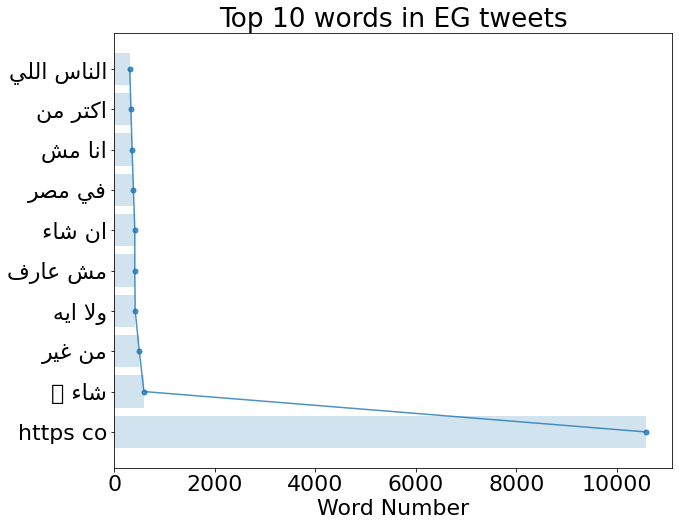

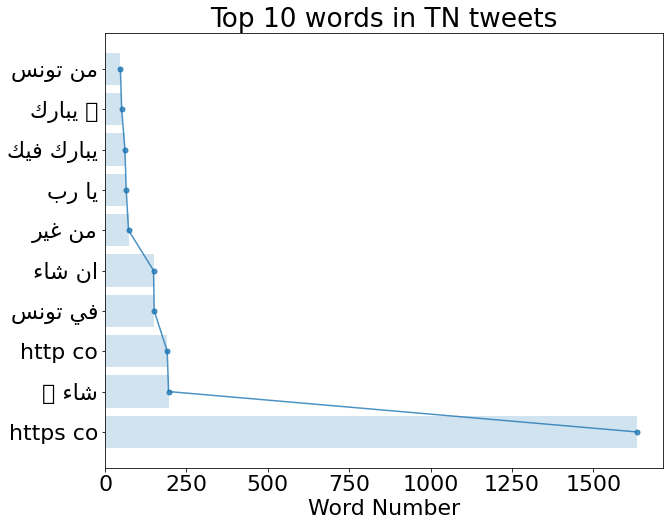

In [11]:
get_top_tweet_bigrams(df, 'tweets', dialect='EG', n=10)
get_top_tweet_bigrams(df, 'tweets', dialect='TN', n=10)
#for dialect in df.dialect.unique():
#    get_top_tweet_bigrams(df, 'tweets', dialect=dialect, n=10)

###### 

### `Clean Text`
Next step to try several methods **one at a time** to clean our tweets like:-

        * Select arabic characters only from text
        * Remove username "@handle" from text
        * Remove URL from text
        * Remove punctuation, emoji and smileys from text
        * Remove \n, \t ,,, etc from text
        * Remove Diacritization from text
        * Remove Arabic Stop Words from text

#### `Select arabic characters only from text`

In [12]:
ar_pattern = r'[\u0600-\u06FF]+'
test_text = df.tweets.iloc[254]
test_text

'@zk2rr @Khaledabowesal بالله ابو وصال بطريقك اعطي فارس ضحكة او امدحه عشان يفرح انه عزز لك وكذا'

In [13]:
' '.join(re.findall(ar_pattern, test_text)) # return arabic tokens only

'بالله ابو وصال بطريقك اعطي فارس ضحكة او امدحه عشان يفرح انه عزز لك وكذا'

In [14]:
re.sub(ar_pattern, ' ', test_text) # return non arabic tokens

'@zk2rr @Khaledabowesal                              '

#### `Remove username "@handle"`

In [15]:
handle_pattern = r'(@.*?)[\s]'

In [16]:
re.sub(handle_pattern, ' ', test_text) # return text without @handle

'  بالله ابو وصال بطريقك اعطي فارس ضحكة او امدحه عشان يفرح انه عزز لك وكذا'

#### `Remove URL`

In [17]:
url_pattern = r'https?://\S+|www\.\S+'
test_text = df.tweets.iloc[1851]
test_text

'هاد النفسية @offgao بمشي بتويتر وبيحط للناس بلوك..\nريتويت اذا عاملك انت التاني بلوك 😂😂😂 https://t.co/KdUgVWrFiP'

In [18]:
re.findall(url_pattern, test_text) # return url only

['https://t.co/KdUgVWrFiP']

In [19]:
re.compile(r'https?://\S+|www\.\S+').sub(r'', test_text) # return text without url

'هاد النفسية @offgao بمشي بتويتر وبيحط للناس بلوك..\nريتويت اذا عاملك انت التاني بلوك 😂😂😂 '

#### `Remove punctuation, emoji and smileys`

In [20]:
url_pattern = r'[^\w\s]'
test_text = df.tweets.iloc[0]
test_text

'يعني من الساعة 1 وانا بحاول انام ولهلا كل المحاولات فشلت 🤦🏼\u200d♀️دقوم اتسحر  احسن اشي 😋\nو مشواري ع الجامعة  الله يكون بالعون كيف بدي اصحصحله 😭🤦🏼\u200d♀️'

In [21]:
re.findall(url_pattern, test_text)

['🤦', '🏼', '\u200d', '♀', '️', '😋', '😭', '🤦', '🏼', '\u200d', '♀', '️']

> this do the same as remove emojy. plus it removes punctuation and smily faces

In [22]:
re.sub(url_pattern, '', test_text)

'يعني من الساعة 1 وانا بحاول انام ولهلا كل المحاولات فشلت دقوم اتسحر  احسن اشي \nو مشواري ع الجامعة  الله يكون بالعون كيف بدي اصحصحله '

#### `Remove Escape Codes` 
> Escape Codes like \n, \t ,,, etc

In [23]:
url_pattern = r'\s+'
test_text = df.tweets.iloc[12437]
test_text

'—\n.\n.\n.\n.\nعلى كثرة الزلات اللّي جاتني مِنك ،\nبس مَ عمري حبيت حد كثرك ❤️✨.'

In [24]:
re.findall(url_pattern,  test_text) # return escape codes found in text

['\n',
 '\n',
 '\n',
 '\n',
 '\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ']

In [25]:
re.sub(url_pattern, ' ', test_text).strip() # return text escape codes found in

'— . . . . على كثرة الزلات اللّي جاتني مِنك ، بس مَ عمري حبيت حد كثرك ❤️✨.'

#### `Remove Diacritization` (tashkeel)

In [26]:
url_pattern = r'[\u0617-\u061A\u064B-\u0652]'
test_text = df.tweets.iloc[12437]
test_text

'—\n.\n.\n.\n.\nعلى كثرة الزلات اللّي جاتني مِنك ،\nبس مَ عمري حبيت حد كثرك ❤️✨.'

In [27]:
re.findall(url_pattern,  test_text)

['ّ', 'ِ', 'َ']

In [28]:
re.sub(re.compile(url_pattern),"", test_text) # p_tashkeel

'—\n.\n.\n.\n.\nعلى كثرة الزلات اللي جاتني منك ،\nبس م عمري حبيت حد كثرك ❤️✨.'

#### `Remove Arabic Stop Words`

In [29]:
from nltk.corpus import stopwords
nltk_stopwords = stopwords.words('arabic')
nltk_stopwords[:10]

['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي']

In [30]:
import urllib.request  # the lib that handles the url stuff
target_url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-ar/master/stopwords-ar.txt"

stopwords_ar = []
for line in urllib.request.urlopen(target_url):
    #print(line.decode('utf-8'))
    line = line.decode('utf-8').split("\n")[0]
    stopwords_ar.append(line)
    
stopwords_ar[:10]

['،', 'آض', 'آمينَ', 'آه', 'آهاً', 'آي', 'أ', 'أب', 'أجل', 'أجمع']

In [31]:
test_text = df.tweets.iloc[12437]

def remove_stop_words(text, stopwords):
    words = [word for word in text.split() if word not in stopwords]
    return " ".join(words)    

print(remove_stop_words(test_text, stopwords=stopwords_ar))
print(remove_stop_words(test_text, stopwords=nltk_stopwords))

— . . . . كثرة الزلات اللّي جاتني مِنك بس مَ عمري حبيت حد كثرك ❤️✨.
— . . . . كثرة الزلات اللّي جاتني مِنك ، مَ عمري حبيت حد كثرك ❤️✨.


#### Make a Preprocessing Pipleline from all above methods to try which of them make a positive differnce in score.

In [32]:
def clean_text(text):
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.compile(r'https?://\S+|www\.\S+').sub(r'', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(re.compile(r'[\u0617-\u061A\u064B-\u0652]'),"", text)
    text = remove_stop_words(text, stopwords_ar)
    text = text.strip()
    return text

df['clean_tweets'] = df.tweets.apply(lambda t: clean_text(t))

Let's visualize top 20 tokens after preprocessing pipline.

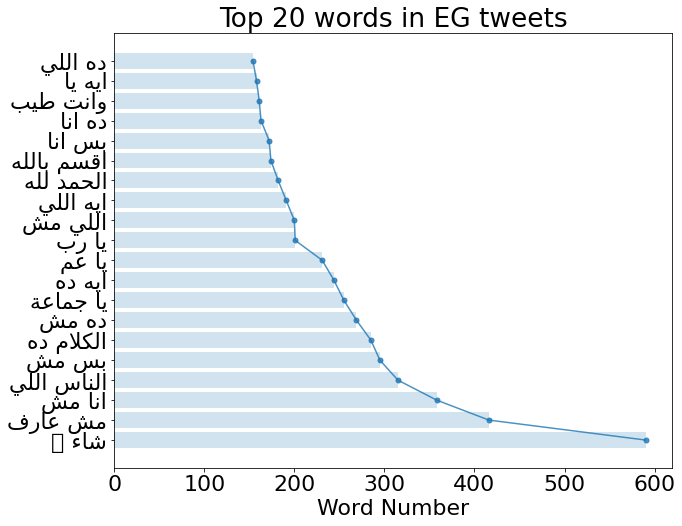

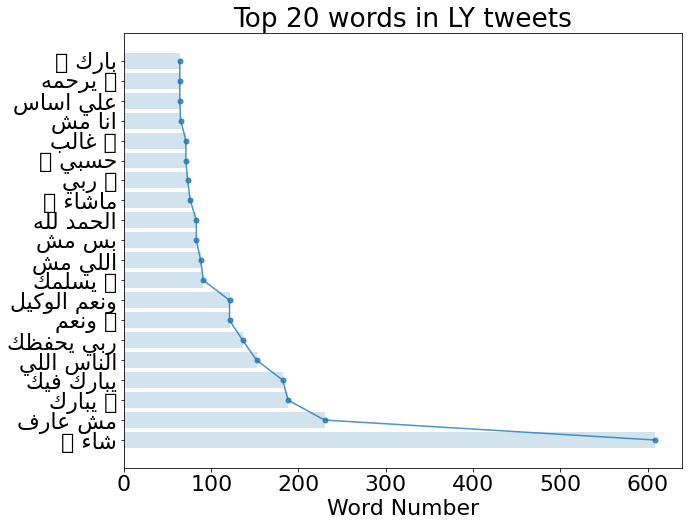

In [33]:
get_top_tweet_bigrams(df, 'clean_tweets', dialect='EG', n=20)
get_top_tweet_bigrams(df, 'clean_tweets', dialect='LY', n=20)
#for dialect in df.dialect.unique():
#    get_top_tweet_bigrams(df, 'clean_tweets', dialect=dialect, n=20)

LabelEncoder to encode target labels with value between 0 and n_classes-1 (0 to 17)

In [34]:
#from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['dialect_encode'] = le.fit_transform( df['dialect'] ).astype(np.int8)
target_names = le.inverse_transform(np.arange(18))
target_names

array(['AE', 'BH', 'DZ', 'EG', 'IQ', 'JO', 'KW', 'LB', 'LY', 'MA', 'OM',
       'PL', 'QA', 'SA', 'SD', 'SY', 'TN', 'YE'], dtype=object)

![](https://miro.medium.com/max/1200/1*3-KkZ0hlRZxjMn7Z6uXDGg.png)

# Major regions for dialects
After run several models we notice that Most of misclassifications happens for each dialect with dialects for share border countries. So we can break a classifier into three to five classifiers. each classifier for a group of share border countries.

Here we can Combine dialects with dialects for share border countries. So let's take a small look here.

Starting with define our new regions for dialects

In [35]:
new_regions = {
    'ar_island': ['QA', 'SA', 'AE', 'KW', 'OM', 'YE','BH'],
    'shaam': ['LB', 'SY', 'JO', 'PL', 'IQ'],
    'africa_ne': ['EG', 'LY', 'SD'],
    'africa_nw': ['TN', 'MA', 'DZ'],
}
new_regions_names = new_regions.keys()
# prepare last dictionary for pandas map function to easly store in dataset
new_regions = {val:key for key, lst in new_regions.items() for val in lst}
#new_regions

Create a function to combine deli

In [36]:
new_df = df.copy()
new_df['region'] = new_df['dialect'].map(new_regions)
new_df.head()

,dialect,tweets,dialect_in_arabic,clean_tweets,dialect_encode,region
1000,PL,يعني من الساعة 1 وانا بحاول انام ولهلا كل المح...,لهجة فلسطينية,يعني الساعة 1 وانا بحاول انام ولهلا المحاولات ...,11,shaam
1001,AE,@nourrr_x هههههههه قلنالج من قبل.. من سنة وانت...,لهجة اماراتية,هههههههه قلنالج وانتوا تترددون هالهتشتاق وعشري...,0,ar_island
1002,PL,دلحق احجزلي طيارة اليوم شوب الجو 😂\nوالله بينش...,لهجة فلسطينية,دلحق احجزلي طيارة شوب الجو والله بينشف ريقي بت...,11,shaam
1003,SA,@KHALID_ASHAERAH وشهوله المنح وصرف الفلوس ع ال...,لهجة سعودية,وشهوله المنح وصرف الفلوس ع الاجانب يعرف حجمة و...,13,ar_island
1004,SY,جاية ع بالي اكلة كبسة😍\nاشتهيتكن معي😂😂\n#رمضان...,لهجة سورية,جاية ع بالي اكلة كبسة اشتهيتكن معي رمضان,15,shaam


In [37]:
new_df.isnull().sum()

dialect              0
tweets               0
dialect_in_arabic    0
clean_tweets         0
dialect_encode       0
region               0
dtype: int64

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, classification_report, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

X = TfidfVectorizer().fit_transform(new_df['tweets'])
y = new_df.region
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.7, shuffle=True, random_state = 42)

model = LinearSVC()
model.fit(X_train, y_train)
predicted = model.predict(X_val)
precision_score(predicted, y_val, average='micro')

0.8259956630150169

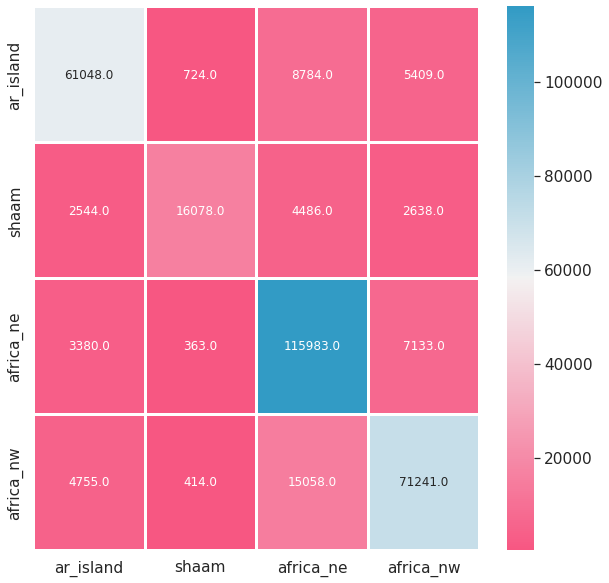

In [39]:
def ConfusionMatrix(cm, target_names):
    #cm = confusion_matrix(y_val, predicted)
    df_cm = pd.DataFrame(cm, target_names, target_names)

    plt.figure(figsize = (10, 10))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(
        df_cm,
        fmt=".1f", annot=True, annot_kws={'size': 12}, cmap=cmap,
        linewidths=3,
    );
    return None

ConfusionMatrix(confusion_matrix(y_val, predicted), new_regions_names)

> We can try to reallocate dialects in diffrent regions for better score.

> ## `Furthermore we can break a classifier into three to five classifiers to classiffy dialects in the same regions.`

![](https://miro.medium.com/max/1200/1*3-KkZ0hlRZxjMn7Z6uXDGg.png)

In [40]:
print("let's stop here for now")
break;

SyntaxError: 'break' outside loop (964718167.py, line 5)

### t-SNE Corpus Visualization
        One very popular method for visualizing document similarity is to use t-distributed stochastic neighbor embedding. By decomposing high-dimensional document vectors into 2 dimensions using probability distributions from both the original dimensionality and the decomposed dimensionality, t-SNE is able to effectively cluster similar documents. By decomposing to 2 or 3 dimensions, the documents can be visualized with a scatter plot.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from yellowbrick.text import TSNEVisualizer

In [ ]:
Vectorized_data = TfidfVectorizer().fit_transform(df['clean_tweets'])
y = df.dialect

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(Vectorized_data, y)
tsne.show()

Note that you can pass the class labels or document categories directly to the TSNEVisualizer as follows:

In [ ]:
tsne = TSNEVisualizer(labels=labels)
tsne.fit(X, y)
tsne.show()